In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

In [2]:
DataWalmart = pd.read_csv("train.csv")

Walmart Sales Data

For the independent practice, we will analyze the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but for simplicity we will focus on analyzing one store.

The data includes:
    
    Store - the store number

    Dept - the department number

    Date - the week

    Weekly_Sales - sales for the given department in the given store

    IsHoliday - whether the week is a special holiday week

#### Load the data and set index to Date


In [3]:
DataWalmart.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True


In [4]:
DataWalmart['Date'] = pd.to_datetime(DataWalmart['Date'])
DataWalmart.set_index('Date', inplace=True)
DataWalmart['Year'] = DataWalmart.index.year  #If you want to acces Year later or Acces Month later
DataWalmart['Month'] = DataWalmart.index.month
DataWalmart.head()

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month
Date,,,,,,
2010-02-05,1,1,24924.50,False,2010,2
2010-02-12,1,1,46039.49,True,2010,2
2010-02-19,1,1,41595.55,False,2010,2
2010-02-26,1,1,19403.54,False,2010,2
2010-03-05,1,1,21827.90,False,2010,3


#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store. Let's call new dataset store1_sales and its variable "Weekly_Sales"


In [5]:
DataWalmart.sort_index(axis = 0, ascending = True, inplace = True)
store1_data = DataWalmart[DataWalmart.Store == 1] #select store 1
store1_sales = store1_data.groupby('Date').sum() #use groupby to get the aggregate over departments
store1_sales[['Weekly_Sales']].head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


#### Plot the Weekly_Sales. What general trends do you observe?


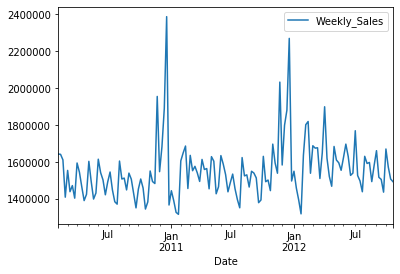

In [6]:
store1_sales[['Weekly_Sales']].plot()

Answer: It might be some correlation between sales and time, because we can see the peak appears in December.

#### Create an autocorrelation plot and explain your findings

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


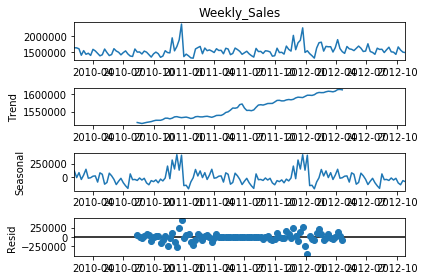

In [7]:
import statsmodels.api as sm
decomposed = sm.tsa.seasonal_decompose(store1_sales.Weekly_Sales, freq = 54, model = 'additive') 
# Using a frequency of 54 representing weekly data
figure = decomposed.plot()
plt.show()

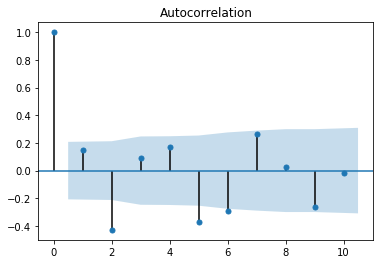

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# ACF plot
plot_acf(decomposed.resid.dropna(), lags = 10)
plt.show()

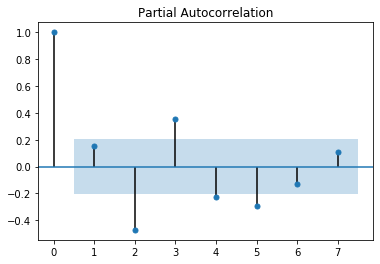

In [9]:
# PACF plot
plot_pacf(decomposed.resid.dropna(), lags =7)
plt.show()

Based on the result, we can't determine which ARMA model we should use.

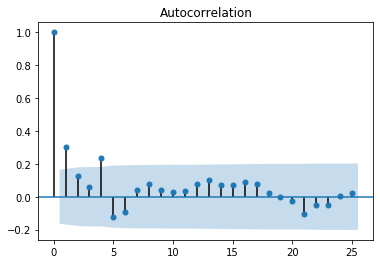

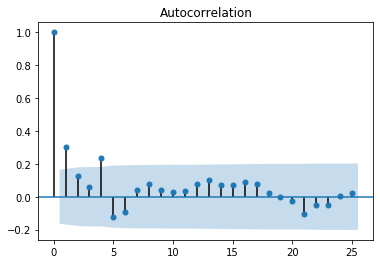

In [10]:
plot_acf(store1_sales.Weekly_Sales, lags=25)

Answer: We observe autocorrelation at 25 lag values. The weekly sales data seems stable with in this graph, which is good, but we haven't see a clear trend for it.

#### Split the weekly sales data in a training and test set - using 80% of the data for training. (In this section we use not-so-great Train/Test split method!

We can only do so in a sequential manner

In [11]:
n = len(store1_sales.Weekly_Sales)

train = store1_sales.Weekly_Sales[:int(.80*n)] #first 80% of data assigned to training set
test = store1_sales.Weekly_Sales[int(.20*n):]  #last 20% of data assigned to our test set

#### Develope an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [12]:
#from statsmodels.tsa.ar_model import AR

#model1 = AR(train).fit(maxlag=1)
#model1.summary()

In [13]:
from statsmodels.tsa.arima_model import ARMA

model1 = ARMA(train, (1, 0)).fit()
model1.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                     ARMA(1, 0)   Log Likelihood               -1528.189
Method:                       css-mle   S.D. of innovations         160453.395
Date:                Sun, 10 May 2020   AIC                           3062.379
Time:                        16:46:21   BIC                           3070.587
Sample:                    02-05-2010   HQIC                          3065.710
                         - 04-06-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.551e+06    2.2e+04     70.487      0.000    1.51e+06    1.59e+06
ar.L1.Weekly_Sales     0.3198      0.090      3.546      0.000       0.143       0.497
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1271           +0.0000j            3.1271            0.0000
-----------------------------------------------------------------------------
"""

In [14]:
#get the start and end date of testing data
print(test.index[0])
print(test.index[len(test)-1])

2010-08-20 00:00:00
2012-10-26 00:00:00


In [15]:
predictions1 = model1.predict(start = '2010-08-20', end = '2012-10-26')
#compute the mean absolute error
from sklearn.metrics import mean_absolute_error
MAE = (mean_absolute_error(test, predictions1)) 
print(MAE)

109392.95271027973


#### Plot the residuals - where are their significant errors.

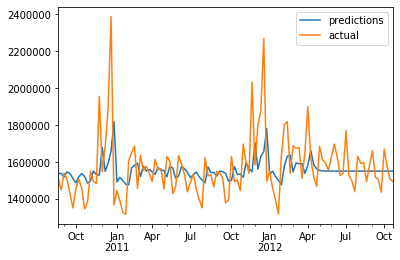

In [16]:
DataFramePredictions = pd.DataFrame(predictions1)
DataFramePredictions['Actual'] = test
DataFramePredictions.columns = ['predictions','actual']
DataFramePredictions.plot()

Answer: The significant errors shows between November to February.

#### Compute and AR(2) model and an ARIMA(3, 1,1) model - does this improve your mean absolute error on the held out set.


In [17]:
#AR(2)
model2 = ARMA(train, (2, 0)).fit()
model2.summary()

predictions2 = model2.predict(start = '2010-08-20', end = '2012-10-26')
#compute the mean absolute error
MAE = (mean_absolute_error(test, predictions2)) 
print(MAE)

109526.2847182811


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [18]:
#ARIMA(3,1,1)
from statsmodels.tsa.arima_model import ARIMA

model3 = ARIMA(train, (3, 1, 1)).fit()
model3.summary()

predictions3 = model3.predict(start = '2010-08-20', end = '2012-10-26', dynamic = False, typ ='levels')
#compute the mean absolute error
MAE = (mean_absolute_error(test, predictions3)) 
print(MAE)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


148292.56473820188


It doesn't improve our mean absolute error on the held out set.

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.


One way without using iterate, but it waste time

In [19]:
warnings.filterwarnings("ignore")
# set d = 0
p = range(0,3)
d = [0]
q = range(0,3)

import itertools
pairs = list(itertools.product(p,d,q)) 

MAE_list = []
for i in range(1,len(pairs)):
    model = ARIMA(train, pairs[i]).fit()
  
    predictions = model.predict(start = '2010-08-20', end = '2012-10-26')
    MAE = (mean_absolute_error(test, predictions)) 
    MAE_list.append(MAE)

print(pairs)
print(MAE_list)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2)]
[109259.40324294308, 109135.8886155875, 109392.95271027973, 109592.80062832986, 109423.52012784059, 109526.2847182811, 108221.38240589097, 106518.54832399811]


In [20]:
best_pair = pairs[np.argmin(MAE_list)]
print (best_pair)
print (np.min(MAE_list))

(2, 0, 1)
106518.54832399811


Another way using intertools and AIC

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [21]:
warnings.filterwarnings("ignore")

p =  q = range(0, 5) 
d = range(0, 3) # Define lag order range
pairs2 = list(itertools.product(p, d, q))

for param in pairs2:
    try: # If there's no error, run this
        mod = ARIMA(train,order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except: # If there's error, run this
        continue

ARIMA(0, 0, 0) - AIC:3072.280139607279
ARIMA(0, 0, 1) - AIC:3064.6469048517947
ARIMA(0, 0, 2) - AIC:3064.185841007188
ARIMA(0, 0, 3) - AIC:3062.143365353132
ARIMA(0, 0, 4) - AIC:3047.3390494439936
ARIMA(0, 1, 0) - AIC:3079.4529270536
ARIMA(0, 1, 1) - AIC:3044.9274203628706
ARIMA(0, 1, 2) - AIC:3039.274441344923
ARIMA(0, 1, 3) - AIC:3039.6939267844223
ARIMA(0, 1, 4) - AIC:3036.2913862277765
ARIMA(0, 2, 0) - AIC:3166.020232698168
ARIMA(0, 2, 1) - AIC:3059.8246855255584
ARIMA(0, 2, 2) - AIC:3029.7730212460433
ARIMA(0, 2, 3) - AIC:3025.2513027777445
ARIMA(1, 0, 0) - AIC:3062.3788744695894
ARIMA(1, 0, 1) - AIC:3063.824939021155
ARIMA(1, 0, 2) - AIC:3065.751372742957
ARIMA(1, 1, 0) - AIC:3064.135991227037
ARIMA(1, 1, 1) - AIC:3037.985302787628
ARIMA(1, 1, 2) - AIC:3039.867630661545
ARIMA(1, 1, 3) - AIC:3033.697998354181
ARIMA(1, 1, 4) - AIC:3030.524650621484
ARIMA(1, 2, 0) - AIC:3114.664231508016
ARIMA(1, 2, 1) - AIC:3045.2116980338924
ARIMA(1, 2, 4) - AIC:3029.125859695021
ARIMA(2, 0, 0) - 

Answer: ARIMA(2, 2, 4) is my best model's performance.

# Now, use the correct method and tune your ARIMA model

In [22]:
#ARIMA(2,2,4)
from statsmodels.tsa.arima_model import ARIMA

model4 = ARIMA(train, (2, 2, 4)).fit()
model4.summary()

predictions4 = model4.predict(start = '2010-08-20', end = '2012-10-26', dynamic = False, typ ='levels')
#compute the mean absolute error
MAE = (mean_absolute_error(test, predictions4)) 
print(MAE)

124400.41388204819
